In [1]:
# prompt: install from torch_geometric.nn import GCNConv

!pip install -q torch-geometric
from torch_geometric.nn import GCNConv
!pip install scikit-learn matplotlib joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.9 MB/s eta 0:00:00


In [2]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Found 159 common nodes for the graph.
Added 10 new physical edges to enrich the graph.
Final enriched graph: 159 nodes and 81 edges.

--- Loading Saved Model and Scaler ---
Model and scaler loaded successfully.

--- Recalculating Anomaly Threshold ---
New anomaly threshold set to: 0.0041571

--- Evaluating on Test Data ---
Processing end-test1.csv...
Processing end-test2.csv...

--- Overall Model Evaluation Report (Threshold Multiplier: 3) ---
              precision    recall  f1-score   support

  Normal (0)       0.97      0.99      0.98    268616
  Attack (1)       0.68      0.27      0.38     11384

    accuracy                           0.97    280000
   macro avg       0.83      0.63      0.68    280000
weighted avg       0.96      0.97      0.96    280000



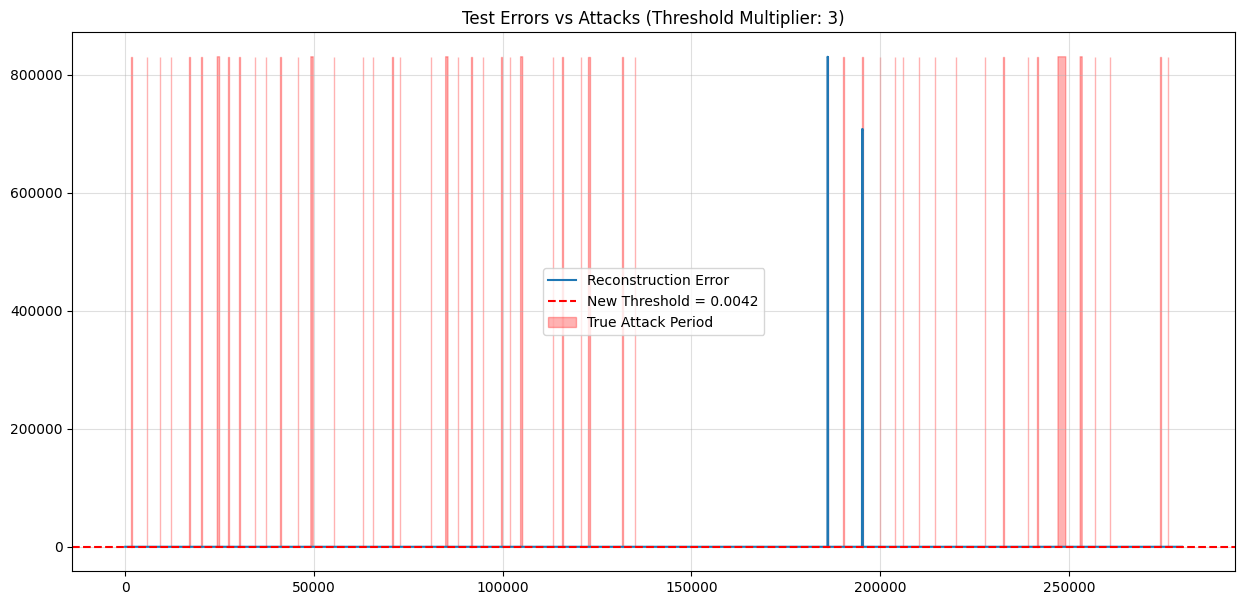

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import joblib

# --- Step 1: Define Paths, Hyperparameters, and Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.set_float32_matmul_precision('high')

# Define all file and output paths
BASE_DIR = ''
GRAPH_PATH = os.path.join(BASE_DIR, '')
DATA_DIR = os.path.join(BASE_DIR, 'dataset/haiend-23.05/')
# This can be the same output directory or a new one for evaluation results
OUTPUT_DIR = os.path.join(BASE_DIR, 'output_a100_evaluation/')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- IMPORTANT: Paths to your SAVED model and scaler ---
SAVED_MODEL_PATH = os.path.join(BASE_DIR, 'output_a100_vectorized/vectorized_model.pth')
SCALER_PATH = os.path.join(BASE_DIR, 'output_a100_vectorized/vectorized_scaler.gz')

# Paths to the data needed for evaluation
TRAIN_FILES = [os.path.join(DATA_DIR, f'end-train{i}.csv') for i in range(1, 5)] # Needed to calculate threshold
TEST_FILES = [os.path.join(DATA_DIR, 'end-test1.csv'), os.path.join(DATA_DIR, 'end-test2.csv')]
LABEL_FILES = [os.path.join(DATA_DIR, 'label-test1.csv'), os.path.join(DATA_DIR, 'label-test2.csv')]

# Paths for saving evaluation results
REPORT_PATH = os.path.join(OUTPUT_DIR, 'evaluation_report_threshold_3.txt')
TEST_PLOT_PATH = os.path.join(OUTPUT_DIR, 'evaluation_results_threshold_3.png')

# --- Hyperparameters (Must be identical to the ones used for training) ---
SEQUENCE_LENGTH = 20
BATCH_SIZE = 10000
HIDDEN_DIM = 512
LATENT_DIM = 128

# --- Step 2: Define Helper Functions and Model Class (Must be identical to training script) ---
def get_name_map(all_node_ids, csv_columns):
    node_to_column_map = {}
    for node_id in all_node_ids:
        patterns = [
            node_id, f"DM-{node_id}", f"{node_id}-OUT",
            f"DM-{node_id}-D", f"DM-{node_id}-R", f"DM-{node_id}-Z",
        ]
        for name in patterns:
            if name in csv_columns:
                node_to_column_map[node_id] = name
                break
    return node_to_column_map

def load_and_build_graph(graph_path, train_files):
    # This function is used here to get the correct graph structure and node list
    try:
        with open(graph_path, 'r') as f:
            graph_data = json.load(f)
        all_node_ids = [node['id'] for node in graph_data['nodes']]
        df_train = pd.concat([pd.read_csv(f, low_memory=False) for f in train_files], ignore_index=True)
        csv_columns = df_train.columns.tolist()
        node_to_column_map = get_name_map(all_node_ids, csv_columns)
        common_nodes_ids = list(node_to_column_map.keys())
        columns_to_use = list(node_to_column_map.values())
        node_map_int = {node_id: i for i, node_id in enumerate(common_nodes_ids)}
        print(f"Found {len(common_nodes_ids)} common nodes for the graph.")
        edges = [
            [node_map_int[link['source']], node_map_int[link['target']]]
            for link in graph_data['links']
            if link['source'] in node_map_int and link['target'] in node_map_int
        ]
        physical_edges_to_add = [
            ('PIT01', 'TIT01'), ('LIT01', 'FCV03'), ('PP01A', 'PIT01'),
            ('PP02', 'TIT02'), ('PP04', 'TWIT03'), ('FCV01', 'FT02'),
        ]
        added_count = 0
        for src, tgt in physical_edges_to_add:
            if src in node_map_int and tgt in node_map_int:
                if [node_map_int[src], node_map_int[tgt]] not in edges: edges.append([node_map_int[src], node_map_int[tgt]])
                if [node_map_int[tgt], node_map_int[src]] not in edges: edges.append([node_map_int[tgt], node_map_int[src]])
                added_count += 2
        print(f"Added {added_count} new physical edges to enrich the graph.")
        if not edges: raise ValueError("Graph is still empty.")
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        print(f"Final enriched graph: {len(common_nodes_ids)} nodes and {edge_index.shape[1]} edges.")
        return common_nodes_ids, columns_to_use, edge_index
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

def prepare_tensors(df, columns_to_use, scaler, sequence_length):
    df_features = df[columns_to_use].copy()
    for col in df_features.columns:
        df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
    df_features.fillna(0, inplace=True)
    data_normalized = scaler.transform(df_features)
    sequences = [data_normalized[i:i+sequence_length] for i in range(len(data_normalized) - sequence_length + 1)]
    return torch.tensor(np.array(sequences), dtype=torch.float32).permute(0, 2, 1)

class VectorizedGraphAutoencoder(nn.Module):
    def __init__(self, num_nodes, num_features, hidden_dim, latent_dim):
        super(VectorizedGraphAutoencoder, self).__init__()
        self.gcn1 = GCNConv(num_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, latent_dim)
        self.relu = nn.ReLU()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, num_features)
        )
    def forward(self, x_batch, base_edge_index):
        B, N, F = x_batch.shape
        x_reshaped = x_batch.reshape(-1, F)
        edge_index_list = [base_edge_index + i * N for i in range(B)]
        expanded_edge_index = torch.cat(edge_index_list, dim=1)
        h = self.relu(self.gcn1(x_reshaped, expanded_edge_index))
        latent = self.gcn2(h, expanded_edge_index)
        reconstructed_reshaped = self.decoder(latent)
        return reconstructed_reshaped.reshape(B, N, F)

# --- Main Evaluation Execution ---
common_nodes_ids, columns_to_use, edge_index = load_and_build_graph(GRAPH_PATH, TRAIN_FILES)

if common_nodes_ids:
    NUM_NODES = len(common_nodes_ids)
    edge_index = edge_index.to(device)

    # 1. Load the trained model and scaler
    print("\n--- Loading Saved Model and Scaler ---")
    model = VectorizedGraphAutoencoder(NUM_NODES, SEQUENCE_LENGTH, HIDDEN_DIM, LATENT_DIM)
    model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    scaler = joblib.load(SCALER_PATH)
    print("Model and scaler loaded successfully.")

    # 2. Recalculate threshold with the new multiplier
    print("\n--- Recalculating Anomaly Threshold ---")
    df_train = pd.concat([pd.read_csv(f, low_memory=False) for f in TRAIN_FILES], ignore_index=True)
    train_tensors = prepare_tensors(df_train, columns_to_use, scaler, SEQUENCE_LENGTH)
    with torch.no_grad():
        eval_loader = DataLoader(train_tensors, batch_size=BATCH_SIZE)
        train_recon_errors = []
        for batch in eval_loader:
            if batch.shape[0] != BATCH_SIZE: continue
            batch = batch.to(device)
            reconstructed = model(batch, edge_index)
            errors = torch.mean((reconstructed - batch)**2, dim=(1,2))
            train_recon_errors.extend(errors.cpu().numpy())

    # Set the new threshold with multiplier = 3
    threshold = np.mean(train_recon_errors) + 3 * np.std(train_recon_errors)
    print(f"New anomaly threshold set to: {threshold:.7f}")

    # 3. Evaluate on Test Data using the new threshold
    print("\n--- Evaluating on Test Data ---")
    all_predictions, all_true_labels, all_test_errors = [], [], []
    for test_file, label_file in zip(TEST_FILES, LABEL_FILES):
        print(f"Processing {os.path.basename(test_file)}...")
        df_test_current = pd.read_csv(test_file)
        df_label_current = pd.read_csv(label_file)

        test_tensors_current = prepare_tensors(df_test_current, columns_to_use, scaler, SEQUENCE_LENGTH)

        with torch.no_grad():
            test_recon_errors = []
            test_loader = DataLoader(test_tensors_current, batch_size=BATCH_SIZE)
            for batch in test_loader:
                if batch.shape[0] != BATCH_SIZE: continue
                batch = batch.to(device)
                reconstructed = model(batch, edge_index)
                errors = torch.mean((reconstructed - batch)**2, dim=(1,2))
                test_recon_errors.extend(errors.cpu().numpy())

        predictions = [1 if e > threshold else 0 for e in test_recon_errors]

        label_column_name = df_label_current.columns[-1]
        true_labels = df_label_current[label_column_name].values[SEQUENCE_LENGTH-1:]

        min_len = min(len(predictions), len(true_labels))
        all_predictions.extend(predictions[:min_len])
        all_true_labels.extend(true_labels[:min_len])
        all_test_errors.extend(test_recon_errors[:min_len])

    # 4. Final Report and Plotting
    report = classification_report(all_true_labels, all_predictions, target_names=['Normal (0)', 'Attack (1)'], zero_division=0)
    print("\n--- Overall Model Evaluation Report (Threshold Multiplier: 3) ---")
    print(report)
    with open(REPORT_PATH, 'w') as f:
        f.write("Evaluation Report with Threshold Multiplier = 3\n\n" + report)

    plt.figure(figsize=(15, 7))
    plt.plot(all_test_errors, label='Reconstruction Error')
    plt.axhline(threshold, color='r', linestyle='--', label=f'New Threshold = {threshold:.4f}')
    plt.fill_between(range(len(all_true_labels)), 0, max(all_test_errors) if all_test_errors else 1, where=(np.array(all_true_labels) == 1), color='red', alpha=0.3, label='True Attack Period')
    plt.title('Test Errors vs Attacks (Threshold Multiplier: 3)'); plt.legend(); plt.grid(True, alpha=0.4)
    plt.savefig(os.path.join(OUTPUT_DIR, 'evaluation_results_threshold_3.png'))
    plt.show()